# Film PFF Score Analysis and Models 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from statsmodels.sandbox.regression.gmm import IV2SLS
from sklearn.neural_network import MLPClassifier

In [2]:
#This data for current college QB's can be used to test in our model to predict which Quarterbacks will be successful in future
qb_22 = pd.read_csv('current_rookies.csv')
qb_21 = pd.read_csv('cfb21.csv')
qb_20 = pd.read_csv('cfb20.csv')
qb_19 = pd.read_csv('cfb19.csv')
qb_18 = pd.read_csv('cfb18.csv')
qb_17 = pd.read_csv('cfb17.csv')
qb_16 = pd.read_csv('cfb16.csv')
qb_15 = pd.read_csv('cfb15.csv')
qb_14 = pd.read_csv('cfb14.csv')

dataframes = [qb_21, qb_20, qb_19, qb_18, qb_17, qb_16, qb_15, qb_14]
college = pd.concat(dataframes)
under200 = college[college['attempts'] <= 200].index
college.drop(under200, inplace = True)
qbs = college.groupby(['player']).mean()
qbs.reset_index(inplace = True)

nfl_15 = pd.read_csv('nfl_qbs15.csv')
nfl_16 = pd.read_csv('nfl_qbs16.csv')
nfl_17 = pd.read_csv('nfl_qb17.csv')
nfl_18 = pd.read_csv('nfl_qb18.csv')
nfl_19 = pd.read_csv('nfl_qb19.csv')
nfl_20 = pd.read_csv('nfl_qb20.csv')
nfl_21 = pd.read_csv('nfl_qb21.csv')
nfl_22 = pd.read_csv('nfl_qb22.csv')

dataframes = [nfl_22, nfl_21, nfl_20, nfl_19, nfl_18, nfl_17, nfl_16, nfl_15]
nfl_qbs = pd.concat(dataframes)
under200 = nfl_qbs[nfl_qbs['attempts'] <= 200].index
nfl_qbs.drop(under200, inplace = True)
nfl_qbs = nfl_qbs.groupby(['player']).mean()
nfl_qbs.reset_index(inplace = True)

# About PFF Scores

PFF grades are scored on an individual play basis, with the scores seen in this data set an averaged per game score for each season. These scores are determined by a number of factors, including player position, type of play run, success of play, down and distance, field position, player matched up against, and defensive coverage. Each play is observed and voted on by a panel of roughly 100 experts, making the scoring somewhat subjective. However, the factors are each weighted in a model to determine the final grade for each play, allowing for normalization across plays. A score of 70+ for a game or an average for the season is considered just above average, while 90+ is elite. While the system can be imperfect, this allows for a distinction between statisitics, which are often biased by the abilities of those around them on the field and at times random chance, and what one is actually doing themsleves on the field. This is especially important in evaluating players during the NFL draft, as a player who is held back by lesser college teammates will not face this same challenge next to professionals in the NFL, and vice versa. This also allows for players to be more accurately evaluated in plays they are not directly involved in recording stats, such as a play where a quarterback hands off a pass to a running back. Although it cannot be a used as an end-all determinaton for player ability, this allows for a player to be evaulated in a different, more individualized landscape while also taking into account plays where they may be directly involved.

In [3]:
#Take the averages for important statisitcs
average_grade_offense = np.mean(qbs['grades_offense'])
average_grade_pass = np.mean(qbs['grades_pass'])
average_grade_rush = np.mean(qbs['grades_run'])
average_grade_fumble = np.mean(qbs['grades_hands_fumble'])
print(average_grade_offense, average_grade_pass, average_grade_rush, average_grade_fumble)

75.22090600775195 74.10707364341089 61.09784399224808 56.23798449612399


In [4]:
#Dropping all QB's in college data set who did not make the NFL
qbs['pro'] = qbs['player'].isin(nfl_qbs['player'])
nonpro = qbs[qbs['pro'] == False].index
qbs.drop(nonpro, inplace = True)
qbs

nfl_qbs['pro'] = nfl_qbs['player'].isin(qbs['player'])
nonpro = nfl_qbs[nfl_qbs['pro'] == False].index
nfl_qbs.drop(nonpro, inplace = True)

# Linear Regression Model

In [5]:
#Create a combined dataset of pro and college stats for easier usage
qbs_lr = qbs.add_suffix("_college")
qbs_lr['player'] = qbs_lr['player_college']
lrdata = pd.merge(nfl_qbs, qbs_lr, on = "player")
lrdata.head()

,player,player_id,player_game_count,accuracy_percent,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,...,sacks_college,scrambles_college,spikes_college,thrown_aways_college,touchdowns_college,turnover_worthy_plays_college,twp_rate_college,yards_college,ypa_college,pro_college
0,Baker Mayfield,46518.0,14.4,72.200,414.800000,451.8,8.860000,2.810000,11.600000,25.600000,...,27.333333,32.666667,1.0,10.333333,39.666667,12.0,2.533333,4097.333333,10.566667,True
1,Brett Hundley,9580.0,11.0,73.200,284.000000,316.0,7.800000,3.000000,6.000000,8.000000,...,41.000000,55.000000,3.0,11.000000,22.000000,16.0,3.100000,3141.000000,7.900000,True
2,C.J. Beathard,11859.0,6.0,69.200,201.000000,224.0,8.100000,2.590000,6.000000,8.000000,...,30.000000,40.000000,2.0,13.000000,17.000000,12.0,2.600000,2815.000000,7.700000,True
3,Dak Prescott,10769.0,15.5,75.550,486.166667,516.5,8.716667,2.781667,6.333333,22.333333,...,26.000000,21.500000,1.0,7.500000,28.000000,20.0,3.950000,3624.000000,8.300000,True
4,Daniel Jones,39395.0,13.5,75.675,399.000000,435.0,7.525000,2.807500,7.750000,14.500000,...,29.666667,22.666667,1.0,13.333333,17.333333,21.0,4.133333,2733.333333,6.433333,True


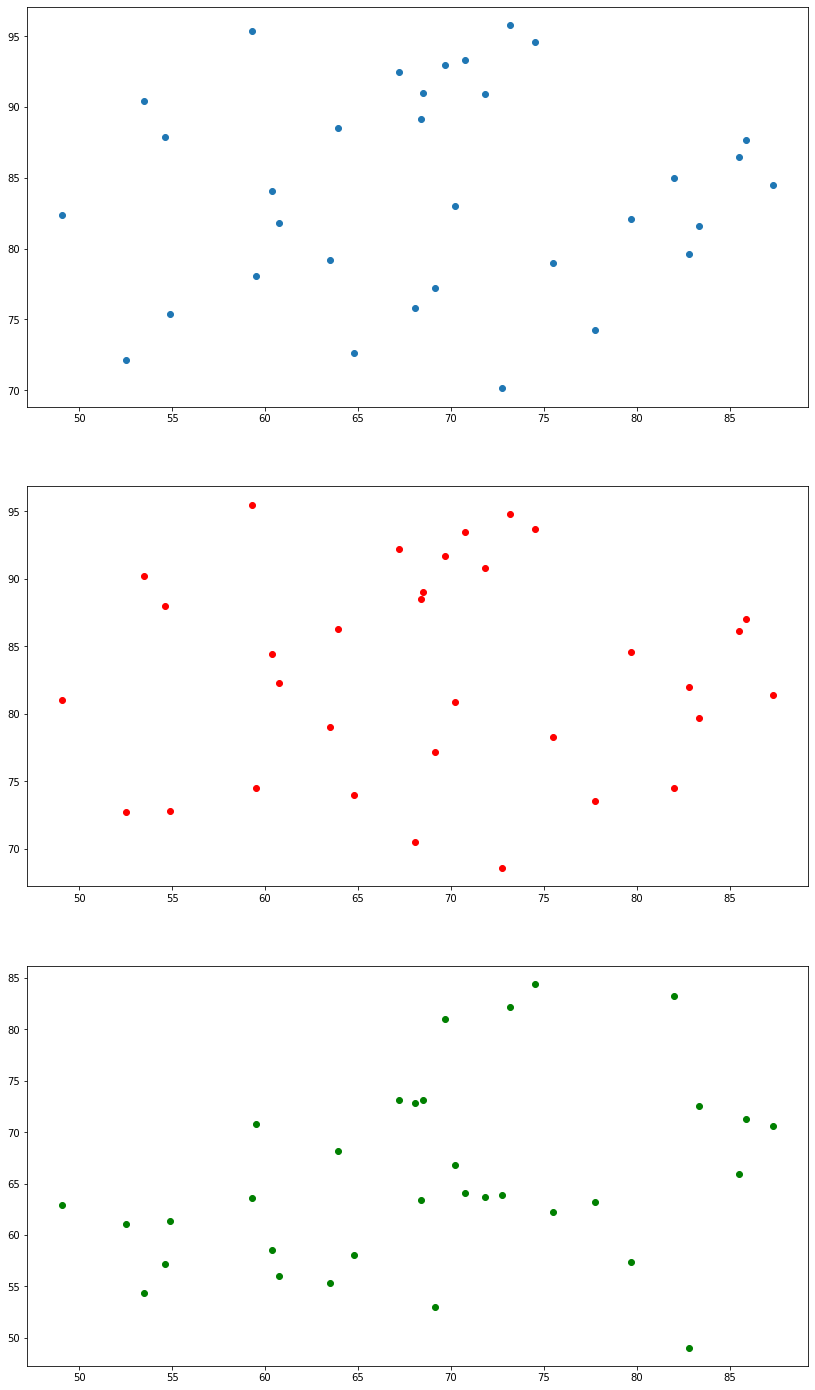

In [36]:
#Plot the data to get a glance at the relationship between grade variables
plt.figure(figsize = (14,25))
plt.subplot(3,1,1)
plt.scatter(lrdata['grades_offense'], lrdata['grades_offense_college'])
plt.subplot(3,1,2)
plt.scatter(lrdata['grades_offense'], lrdata['grades_pass_college'], c = "red")
plt.subplot(3,1,3)
plt.scatter(lrdata['grades_offense'], lrdata['grades_run_college'], c = "green")

In [38]:
#Create a dataset that contains only the values needed for regression
lrdata_drop = lrdata.loc[:,['grades_pass_college', 'grades_offense_college', 'grades_run_college']]
lrdata_drop = sm.add_constant(lrdata_drop)

#Create the initial OLS regression model to find predicitve value of college grades on professional grades
grade_linear_model = sm.OLS(lrdata['grades_offense'], lrdata_drop).fit()
grade_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         grades_offense   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.380
Date:                Sun, 23 Apr 2023   Prob (F-statistic):              0.268
Time:                        14:35:54   Log-Likelihood:                -121.52
No. Observations:                  33   AIC:                             251.0
Df Residuals:                      29   BIC:                             257.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     49.7625     21.598      2.304      0.029       5.589      93.936
grades_pass_college        0.7027      1.097      0.641      0.527      -1.540       2.946
grades_offense_college    -0.9041      1.255     -0.720      0.477      -3.471       1.663
grades_run_college         0.5647      0.315      1.795      0.083      -0.079       1.208
==============================================================================
Omnibus:                        0.586   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.695
Skew:                           0.200   Prob(JB):                        0.707
Kurtosis:                       2.413   Cond. No.                     1.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model shows what we could infer from plotting the data, which is that only a small portion of the pro overall offensive ability grade is described by college grades. This is evidenced by the r-squared value of just 0.125, which would evidence the importance of our models using player statistics and measurables when making draft decisions. However, this could still play a part in decisions made and could be used as a deciding factor if two players are very similar in other models. This model shows that college rushing grades are the most significant, which would signal that a quarterback with strong mobility may see this trait translate better in pro football than other abilities such as passing.

# How do attempts impact

One question that seems important to consider is to ask whether attempting more passes each year, and in turn providing more data points for the total PFF grades to be built off of, will be more predicitive of in determing their professional grade. This could useful in evaluation of players, as it could show whether it is favorable to fade players with less experience in college or whether this is not something to take into serious coinsideration.

In [8]:
#Calculate correlation matrix for college overall offense grade for players
corr_matrix = lrdata.corr()
corr_matrix.loc[['grades_offense_college']]

,player_id,player_game_count,accuracy_percent,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,btt_rate,...,sacks_college,scrambles_college,spikes_college,thrown_aways_college,touchdowns_college,turnover_worthy_plays_college,twp_rate_college,yards_college,ypa_college,pro_college
grades_offense_college,0.456567,0.148664,0.119382,0.027506,0.008351,0.001591,-0.064082,0.062669,0.086269,0.104221,...,-0.327211,-0.129145,-0.115957,-0.163154,0.763852,-0.468866,-0.599397,0.64238,0.803506,NaN


In [9]:
#Creating a 2 stage linear regression attempting to see if college passing attempts act as an instrumental variable for college offense grade
grades_IV_model = IV2SLS(lrdata['grades_offense'], sm.add_constant(lrdata['grades_offense_college']), instrument = lrdata['attempts_college']).fit()
grades_IV_model.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1817: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:         grades_offense   R-squared:                      -0.071
Model:                         IV2SLS   Adj. R-squared:                 -0.106
Method:                     Two Stage   F-statistic:                -2.698e-14
                        Least Squares   Prob (F-statistic):               1.00
Date:                Sun, 23 Apr 2023                                         
Time:                        13:07:03                                         
No. Observations:                  33                                         
Df Residuals:                      31                                         
Df Model:                           1                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     27.4471        nan        nan        nan         nan         nan
grades_offense_college     0.5000        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                        2.650   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                1.339
Skew:                           0.055   Prob(JB):                        0.512
Kurtosis:                       2.019   Cond. No.                         990.
==============================================================================
"""

After creating a two stage OLS model, where the number of attempts per season is acting as the instrumental variable in for college grade in predicting pro grade, we see a negative r-squared value. This would signal that the model is not strongly predictive of the data, so we can discount these results. This would seemingly signal that although a player may attempt less passes and have less college expereince, this does not mean they can't find as much or more success as their peers once in the NFL.

# Multi-Layer Perceptron

To account for the subjectiveity of the data, I decided to use a multilayer perceptron to account for the variability in the data.

In [33]:
print(lrdata['grades_offense'].describe())

count    33.000000
mean     69.116306
std      10.439494
min      49.100000
25%      60.750000
50%      69.150000
75%      75.500000
max      87.320000
Name: grades_offense, dtype: float64


In [30]:
#Create binary classes based on if quarterback is above average(greater than 50th percentile in NFL offensive grade)
lrdata['grade_binary'] = 0
lrdata.loc[lrdata['grades_offense'] >= 69.15, 'grade_binary'] = 1

#Split data into independent and dependent variables and create testing split
x = lrdata.loc[:,['grades_pass_college', 'grades_offense_college', 'grades_run_college']]
y = lrdata['grade_binary']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25)

#Create the MLP model using the train and test data
clf = MLPClassifier().fit(x_train,y_train)
clf.predict(x_test)

array([0, 0, 0, 0, 1, 1, 1, 0, 0])

In [12]:
#Adjust the current draft quarterback data for testing (Using only QB's projected to be drafted from our other model)
qb_22 = qb_22.add_suffix("_college")
qb_22
qb_22 = qb_22[qb_22['player_college'].isin(["Will Levis", "C.J. Stroud", "Bryce Young", "Anthony Richardson", "Hendon Hooker", "Tanner McKee", "Aidan O'Connell"])]

In [31]:
#Fit the current draft QB's to find who it predicts will be above average once in the NFL
current_year_x = qb_22.loc[:,['grades_pass_college', 'grades_offense_college', 'grades_run_college']]
current_year_x
success = clf.predict(current_year_x)

In [32]:
draft_success = pd.DataFrame()
draft_success['player_name'] = qb_22['player_college']
draft_success['model_prediction'] = success
draft_success

,player_name,model_prediction
7,Aidan O'Connell,0
22,Tanner McKee,0
37,C.J. Stroud,0
41,Bryce Young,0
65,Hendon Hooker,1
66,Anthony Richardson,1
81,Will Levis,1


For this model, I set the parameter for sucess of a QB to be an above 50th percentile PFF grade. After creating our model for pro grades based on current NFL QB's, we are able to use it's prediction method to test the model on this current draft's quarterbacks. This model seemed to favor quarterback's with higher rushing ability as was discussed earlier, which woukd seemingly be a more translatable trait in the NFL. While one's passing skill may be put to the test more against high level competition, rushing ability is much more athleticism based, so it would seemingly hold up even against more skilled opponents. In addition, this model supported selecting Levis and Richardson while some of the other models we created did not, which would back up the point made earlier about college experience and attempts being more predictive of success. Levis and Richardson each only played one full season in college, but the model still sees them as having a high probability of success